# Explorative Data Analysis

In [1]:
import os
import sys

if bool(os.environ.get("KAGGLE_URL_BASE", "")):
  import sys
  # running on kaggle
  sys.path.insert(0, "/kaggle/input/hsm-source-files")
else:
  # running locally
  sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.utils import get_raw_data_dir

2025-11-22 14:20:25,932 :: root :: INFO :: Initialising Utils


In [2]:
DATA_PATH = get_raw_data_dir()
TRAIN_DATA_PATH = DATA_PATH / "train.csv"

## Basic form analysis of train.csv

Observations:
- 106'800 rows and 15 columns
- All rows numeric except the `expert_consensus` column (categorical)
- No missing values

In [3]:
train_df = pd.read_csv(TRAIN_DATA_PATH)

print(train_df.head())

print("Train CSV shape", train_df.shape)

       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0   

In [4]:
train_df.dtypes

eeg_id                                int64
eeg_sub_id                            int64
eeg_label_offset_seconds            float64
spectrogram_id                        int64
spectrogram_sub_id                    int64
spectrogram_label_offset_seconds    float64
label_id                              int64
patient_id                            int64
expert_consensus                     object
seizure_vote                          int64
lpd_vote                              int64
gpd_vote                              int64
lrda_vote                             int64
grda_vote                             int64
other_vote                            int64
dtype: object

In [5]:
train_df.isna().sum()

eeg_id                              0
eeg_sub_id                          0
eeg_label_offset_seconds            0
spectrogram_id                      0
spectrogram_sub_id                  0
spectrogram_label_offset_seconds    0
label_id                            0
patient_id                          0
expert_consensus                    0
seizure_vote                        0
lpd_vote                            0
gpd_vote                            0
lrda_vote                           0
grda_vote                           0
other_vote                          0
dtype: int64

## Target variables

Observations:
- Target vote columns aren't propabilities, but actual counts of votes
- The targets are well balanced, with "Seizure" being the most common class (~21k) and "LDP" the least common (~15k)

In [6]:
target_columns = ['seizure_vote', 'lpd_vote','gpd_vote','lrda_vote','grda_vote','other_vote']
consensus_column = ['expert_consensus']

print(train_df[target_columns].head())

   seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote
0             3         0         0          0          0           0
1             3         0         0          0          0           0
2             3         0         0          0          0           0
3             3         0         0          0          0           0
4             3         0         0          0          0           0


  expert_consensus  count
0          Seizure  20933
1             GRDA  18861
2            Other  18808
3              GPD  16702
4             LRDA  16640
5              LPD  14856


/tmp/ipykernel_428222/199952109.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


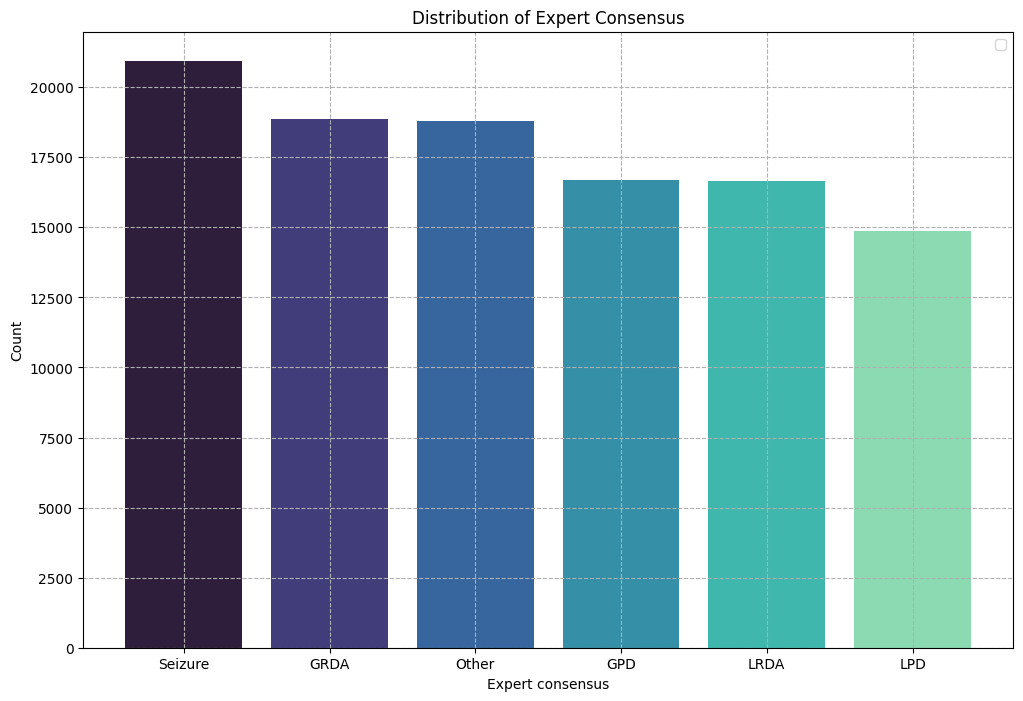

In [7]:
count_df_consensus = train_df['expert_consensus'].value_counts().reset_index()
count_df_consensus.columns=['expert_consensus','count']

print(count_df_consensus)

colors = sns.color_palette("mako", len(count_df_consensus))

plt.figure(figsize=(12,8))
plt.bar(count_df_consensus['expert_consensus'], count_df_consensus['count'], color=colors)
plt.xlabel('Expert consensus')
plt.ylabel('Count')
plt.title('Distribution of Expert Consensus')
plt.legend()
plt.grid(ls='--')
plt.show()

## patient_id

Observations
- 1'950 unique patients in the training set

In [10]:
train_df['patient_id'].nunique()

1950

## eeg_id and sub windows

Observations:
- There are 17'089 unique EEG IDs
- Most EEGs (11k) have less than 5 sub windows, almost all (16k) less than 20. 6k have only 1 sub window. The most is 743 sub windows for one EEG (ID 2259539799)
- The label offset seconds range from 0.0 to 3372.0 seconds (0 - ~56 minutes), with the median being 26 seconds
- Each EEG is associated with exactly one spectrogram

           eeg_id  Count
0      2259539799    743
1      2428433259    664
2      1641054670    562
3      2860052642    534
4       525664301    531
...           ...    ...
17084  3115575521      1
17085  3218602720      1
17086  3851517872      1
17087  3042198969      1
17088  3009745953      1

[17089 rows x 2 columns]
EEG ID with most sub windows 2259539799


/tmp/ipykernel_428222/2163072619.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


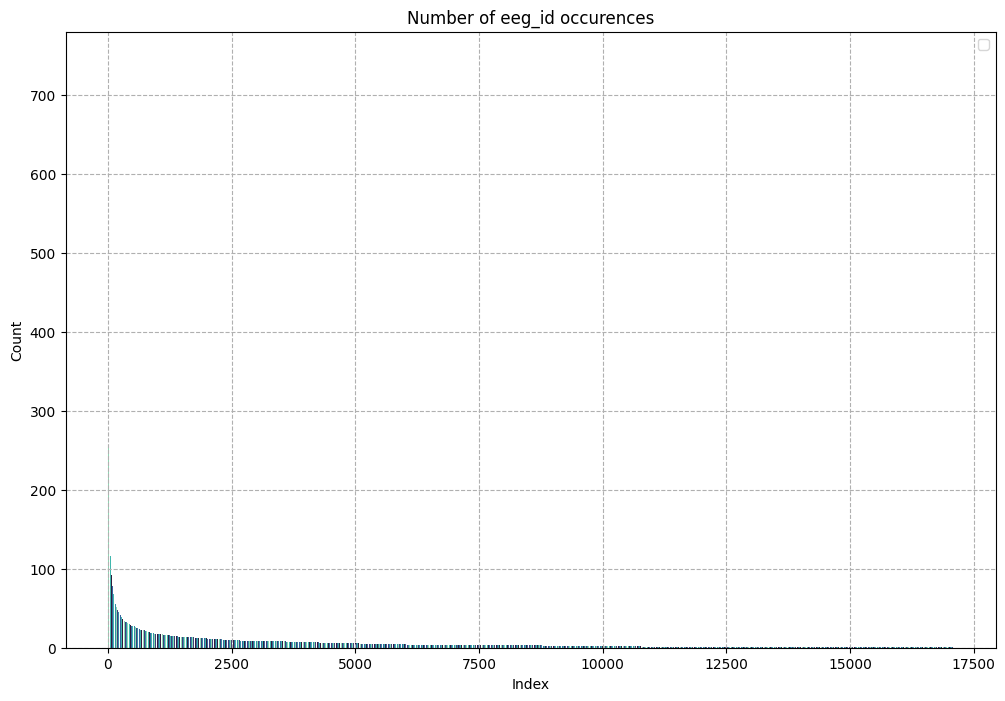

/tmp/ipykernel_428222/2163072619.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


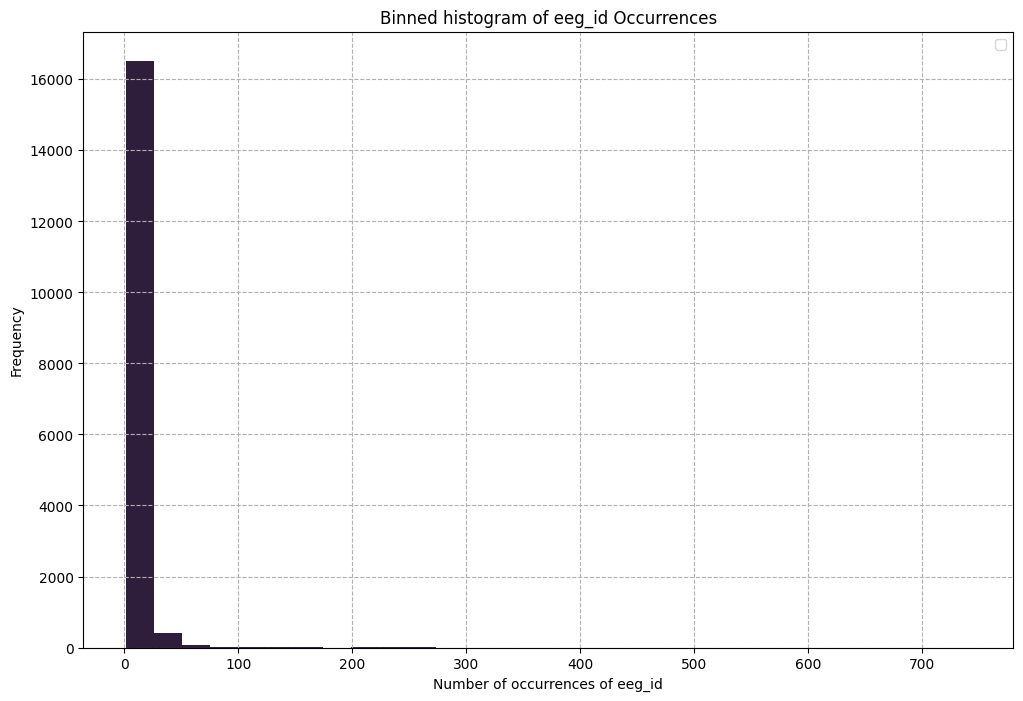

In [8]:
# Count the number of unique eeg_id
df_count_eeg_id = train_df['eeg_id'].value_counts().reset_index()
df_count_eeg_id.columns = ['eeg_id', 'Count']
print(df_count_eeg_id)

print("EEG ID with most sub windows", df_count_eeg_id.loc[df_count_eeg_id['Count'].idxmax()]["eeg_id"])

plt.figure(figsize=(12,8))
plt.bar(df_count_eeg_id.index, df_count_eeg_id['Count'], color=colors)
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Number of eeg_id occurences')
plt.legend()
plt.grid(ls='--')
plt.show()

# Display binned histogram of eeg_id counts
plt.figure(figsize=(12,8))
plt.hist(df_count_eeg_id['Count'], bins=30, color=colors[0])
plt.xlabel('Number of occurrences of eeg_id')
plt.ylabel('Frequency')
plt.title('Binned histogram of eeg_id Occurrences')
plt.legend()
plt.grid(ls='--')
plt.show()

Max eeg_label_offset_seconds 3372.0
Min eeg_label_offset_seconds 0.0
Mean eeg_label_offset_seconds 118.81722846441947
Median eeg_label_offset_seconds 26.0


/tmp/ipykernel_3140/3363441054.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/home/david/miniconda3/envs/aicomp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


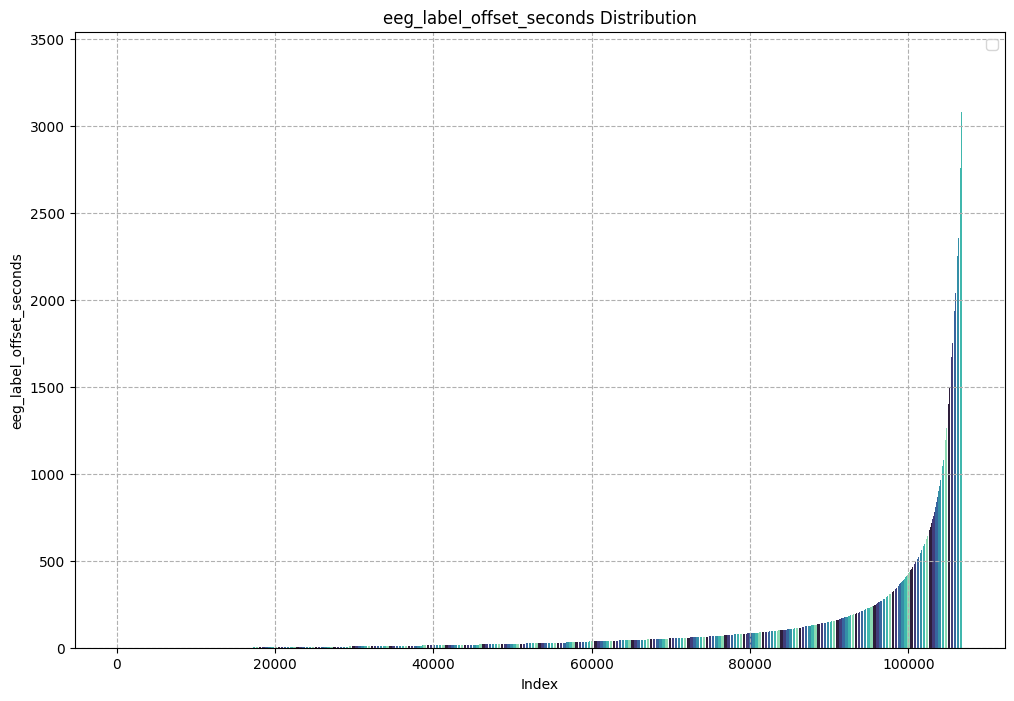

/tmp/ipykernel_3140/3363441054.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


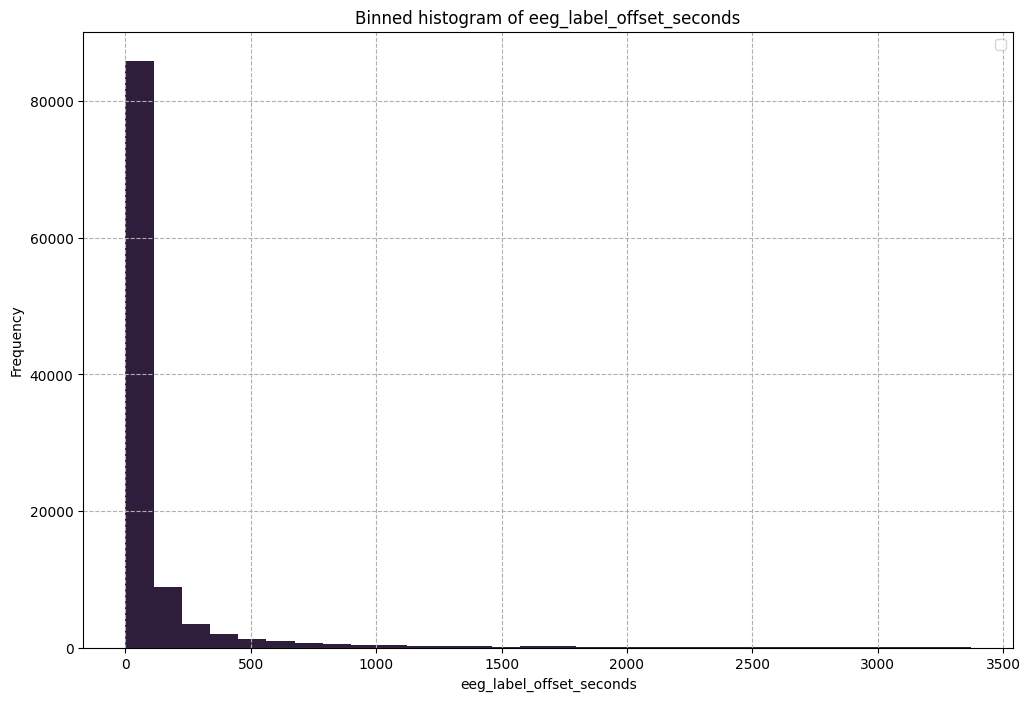

In [130]:
df_eeg_label_offset = train_df['eeg_label_offset_seconds'].sort_values().reset_index(drop=True)

print("Max eeg_label_offset_seconds", df_eeg_label_offset.max())
print("Min eeg_label_offset_seconds", df_eeg_label_offset.min())
print("Mean eeg_label_offset_seconds", df_eeg_label_offset.mean())
print("Median eeg_label_offset_seconds", df_eeg_label_offset.median())

plt.figure(figsize=(12,8))
plt.bar(df_eeg_label_offset.index, df_eeg_label_offset, color=colors)
plt.xlabel('Index')
plt.ylabel('eeg_label_offset_seconds')
plt.title('eeg_label_offset_seconds Distribution')
plt.legend()
plt.grid(ls='--')
plt.show()

plt.figure(figsize=(12,8))
plt.hist(df_eeg_label_offset, bins=30, color=colors[0])
plt.xlabel('eeg_label_offset_seconds')
plt.ylabel('Frequency')
plt.title('Binned histogram of eeg_label_offset_seconds')
plt.legend()
plt.grid(ls='--')
plt.show()

In [131]:
eeg_spectrogram_count = train_df.groupby('eeg_id')['spectrogram_id'].nunique()
eeg_spectrogram_count[eeg_spectrogram_count != 1].any()

np.False_

## spectrogram_id and sub windows

Observations:
- There are 11'138 unique spectrogram IDs
- Most spectrograms (8k) have less than 5 sub windows, almost all (10k) less than 20. 2.4k have only 1 sub window. The most is 1'022 sub windows for one spectrogram (ID 764146759)
- The label offset seconds range from 0.0 to 17632 seconds (0 - ~293 minutes), with the median being 62 seconds

       spectrogram_id  Count
0           764146759   1022
1          1974785580    836
2          1391458063    743
3          1863712617    703
4           577118473    562
...               ...    ...
11133      1662756242      1
11134      1662066256      1
11135      1661391047      1
11136      1661353529      1
11137      1665490767      1

[11138 rows x 2 columns]
Spectrogram ID with most sub windows 764146759


/tmp/ipykernel_3140/3244869723.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


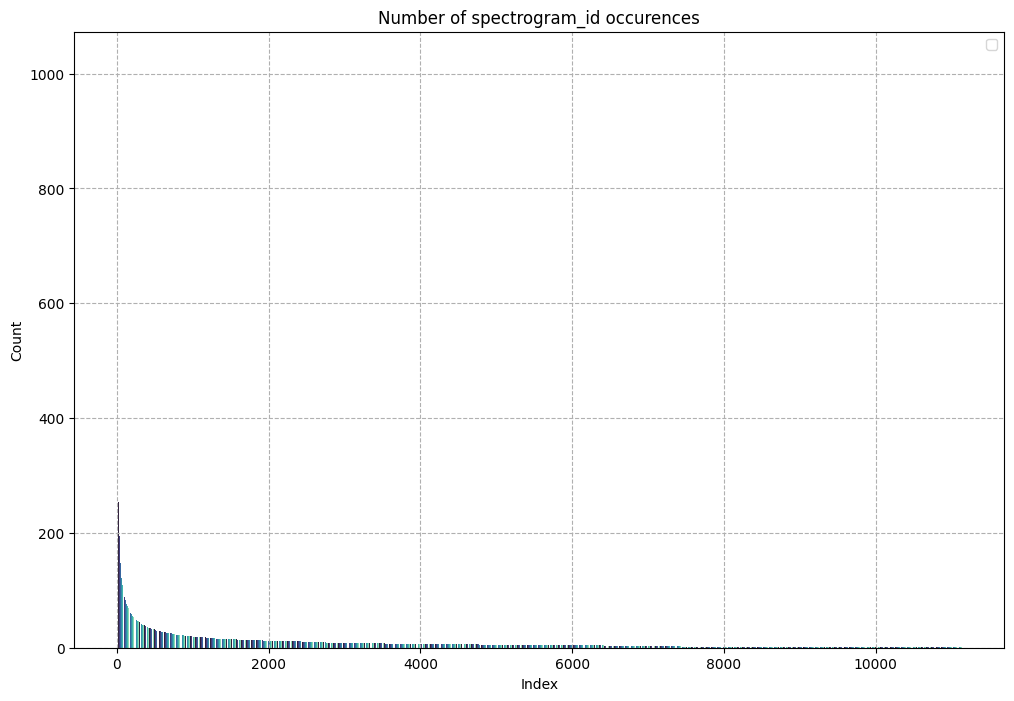

/tmp/ipykernel_3140/3244869723.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


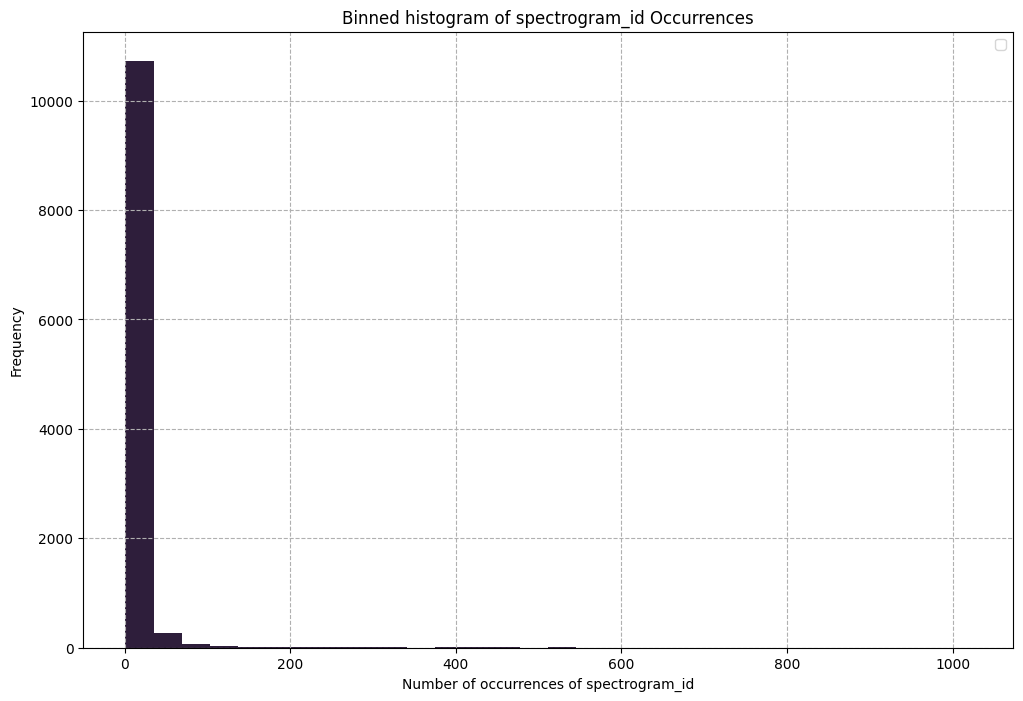

In [132]:
# Count the number of unique spectrogram_id
df_count_spectrogram_id  = train_df['spectrogram_id'].value_counts().reset_index()
df_count_spectrogram_id.columns = ['spectrogram_id', 'Count']
print(df_count_spectrogram_id)

print("Spectrogram ID with most sub windows", df_count_spectrogram_id.loc[df_count_spectrogram_id['Count'].idxmax()]["spectrogram_id"])

plt.figure(figsize=(12,8))
plt.bar(df_count_spectrogram_id.index, df_count_spectrogram_id['Count'], color=colors)
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Number of spectrogram_id occurences')
plt.legend()
plt.grid(ls='--')
plt.show()

# Display binned histogram of spectrogram_id counts
plt.figure(figsize=(12,8))
plt.hist(df_count_spectrogram_id['Count'], bins=30, color=colors[0])
plt.xlabel('Number of occurrences of spectrogram_id')
plt.ylabel('Frequency')
plt.title('Binned histogram of spectrogram_id Occurrences')
plt.legend()
plt.grid(ls='--')
plt.show()

Max spectrogram_label_offset_seconds 17632.0
Min spectrogram_label_offset_seconds 0.0
Mean spectrogram_label_offset_seconds 520.431404494382
Median spectrogram_label_offset_seconds 62.0


/tmp/ipykernel_3140/2902257481.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/home/david/miniconda3/envs/aicomp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


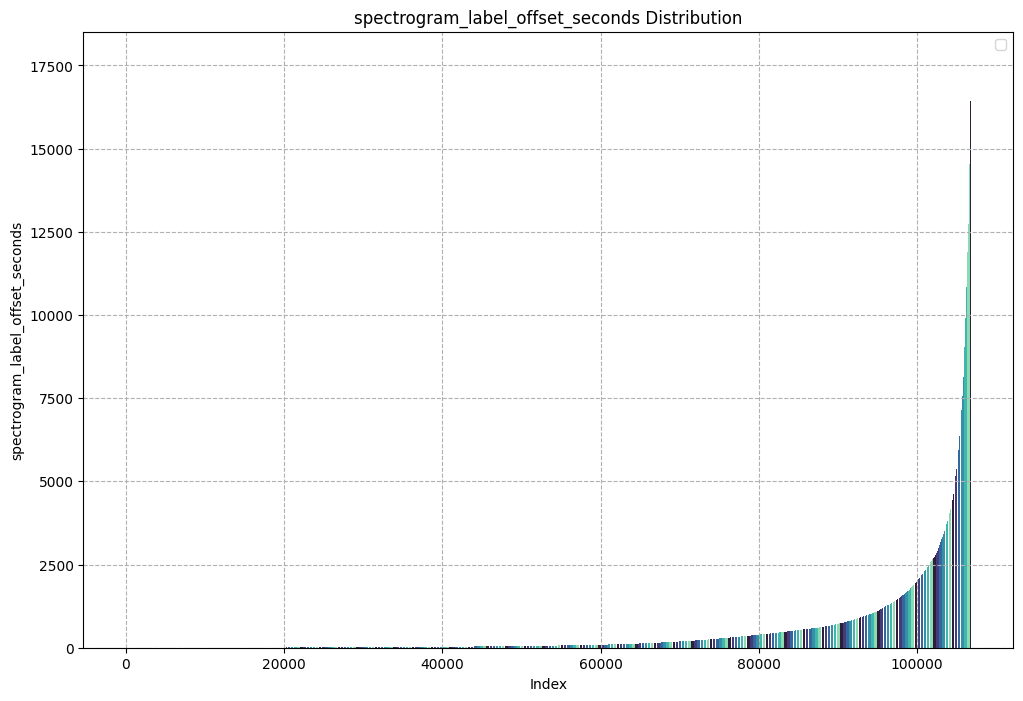

/tmp/ipykernel_3140/2902257481.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


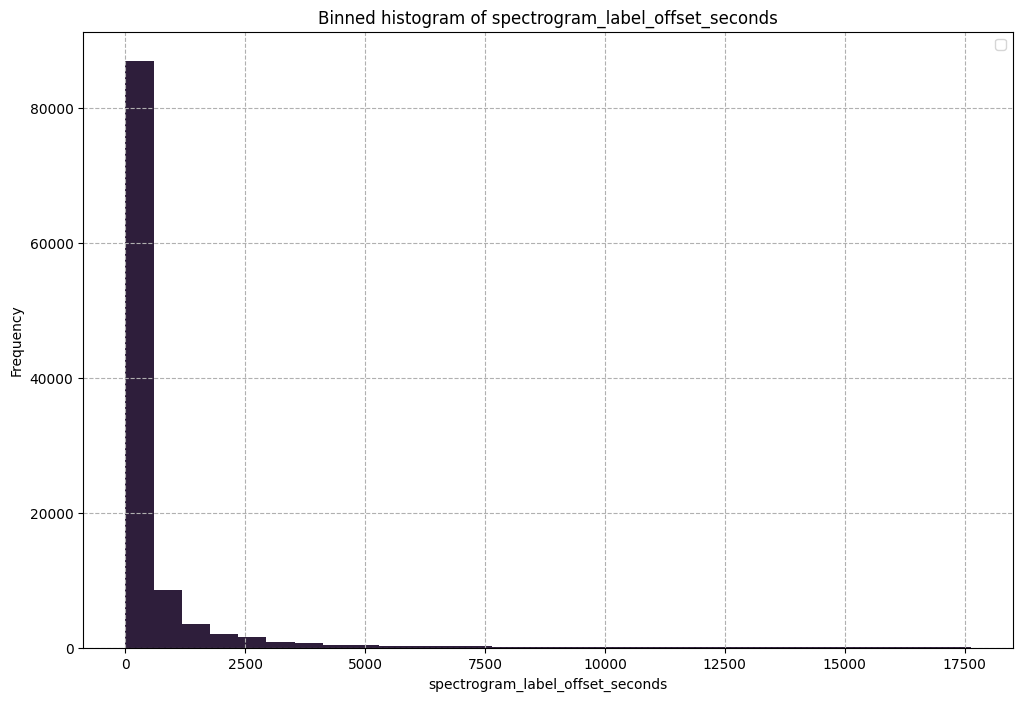

In [133]:
df_spectrogram_label_offset = train_df['spectrogram_label_offset_seconds'].sort_values().reset_index(drop=True)

print("Max spectrogram_label_offset_seconds", df_spectrogram_label_offset.max())
print("Min spectrogram_label_offset_seconds", df_spectrogram_label_offset.min())
print("Mean spectrogram_label_offset_seconds", df_spectrogram_label_offset.mean())
print("Median spectrogram_label_offset_seconds", df_spectrogram_label_offset.median())

plt.figure(figsize=(12,8))
plt.bar(df_spectrogram_label_offset.index, df_spectrogram_label_offset, color=colors)
plt.xlabel('Index')
plt.ylabel('spectrogram_label_offset_seconds')
plt.title('spectrogram_label_offset_seconds Distribution')
plt.legend()
plt.grid(ls='--')
plt.show()

plt.figure(figsize=(12,8))
plt.hist(df_spectrogram_label_offset, bins=30, color=colors[0])
plt.xlabel('spectrogram_label_offset_seconds')
plt.ylabel('Frequency')
plt.title('Binned histogram of spectrogram_label_offset_seconds')
plt.legend()
plt.grid(ls='--')
plt.show()

## patient_id and sub windows

Observations:
- There are 1'950 unique patient IDs
- The most is 2'215 occurences for one patient (ID 30631)

      patient_id  Count
0          30631   2215
1           2641   2185
2          35627   1403
3          28330   1362
4          54199   1350
...          ...    ...
1945       43246      1
1946       33103      1
1947       43255      1
1948       38896      1
1949        4850      1

[1950 rows x 2 columns]
Patient ID with most occurences 30631


/tmp/ipykernel_3140/1913140762.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


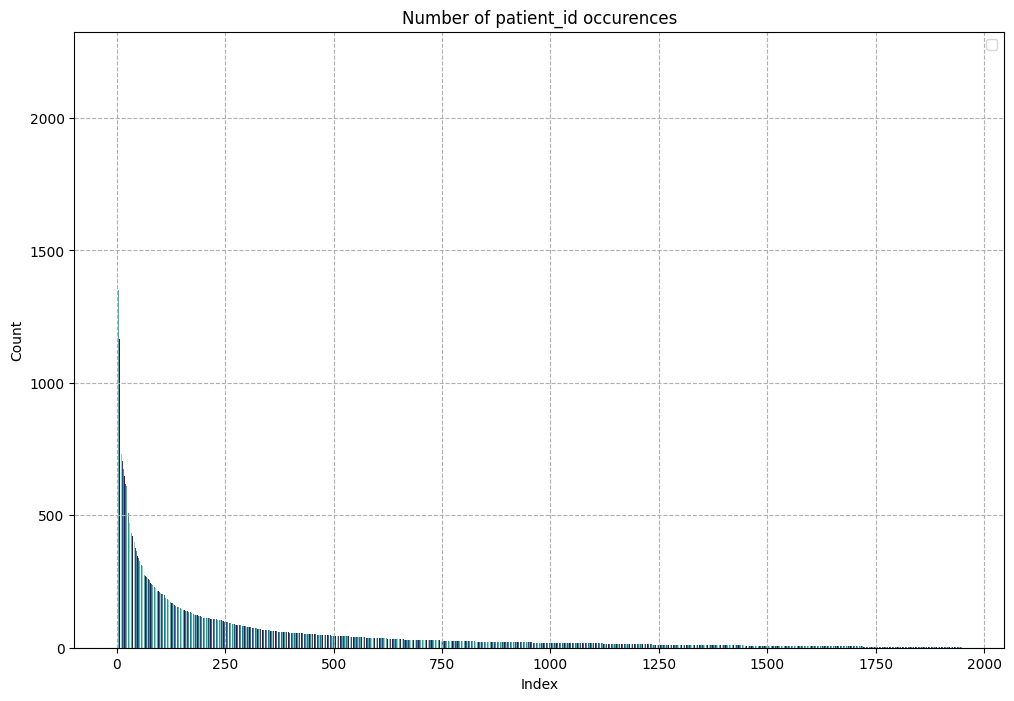

/tmp/ipykernel_3140/1913140762.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


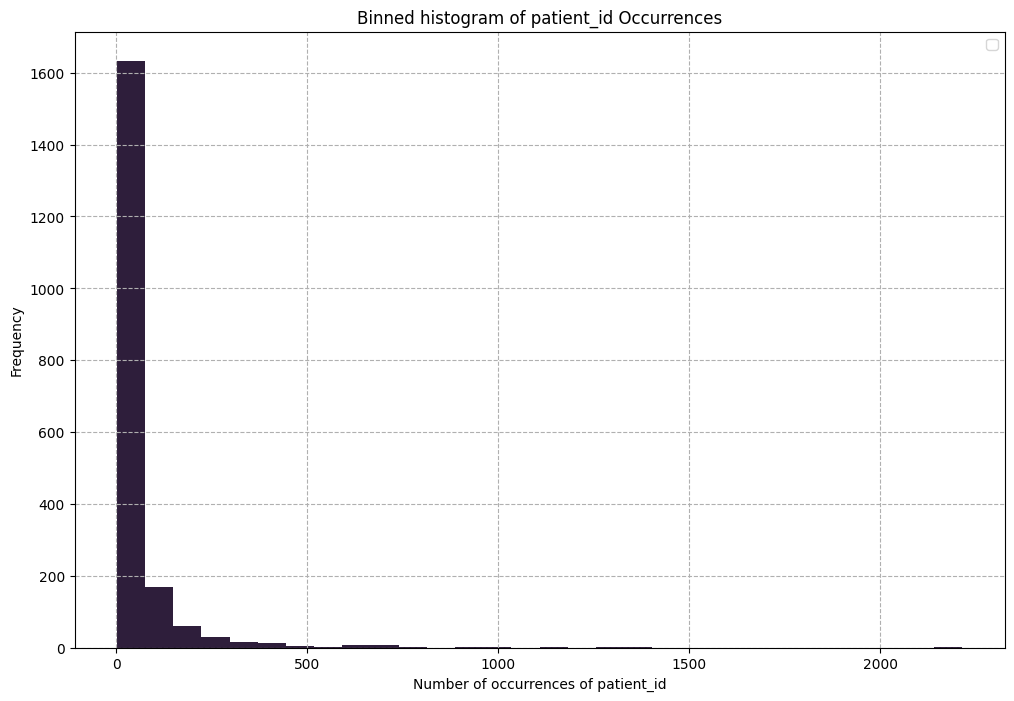

In [134]:
# Count the number of unique patient_id
df_count_patient_id  = train_df['patient_id'].value_counts().reset_index()
df_count_patient_id.columns = ['patient_id', 'Count']
print(df_count_patient_id)

print("Patient ID with most occurences", df_count_patient_id.loc[df_count_patient_id['Count'].idxmax()]["patient_id"])

plt.figure(figsize=(12,8))
plt.bar(df_count_patient_id.index, df_count_patient_id['Count'], color=colors)
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Number of patient_id occurences')
plt.legend()
plt.grid(ls='--')
plt.show()

# Display binned histogram of patient_id counts
plt.figure(figsize=(12,8))
plt.hist(df_count_patient_id['Count'], bins=30, color=colors[0])
plt.xlabel('Number of occurrences of patient_id')
plt.ylabel('Frequency')
plt.title('Binned histogram of patient_id Occurrences')
plt.legend()
plt.grid(ls='--')
plt.show()

/tmp/ipykernel_3140/1506194475.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


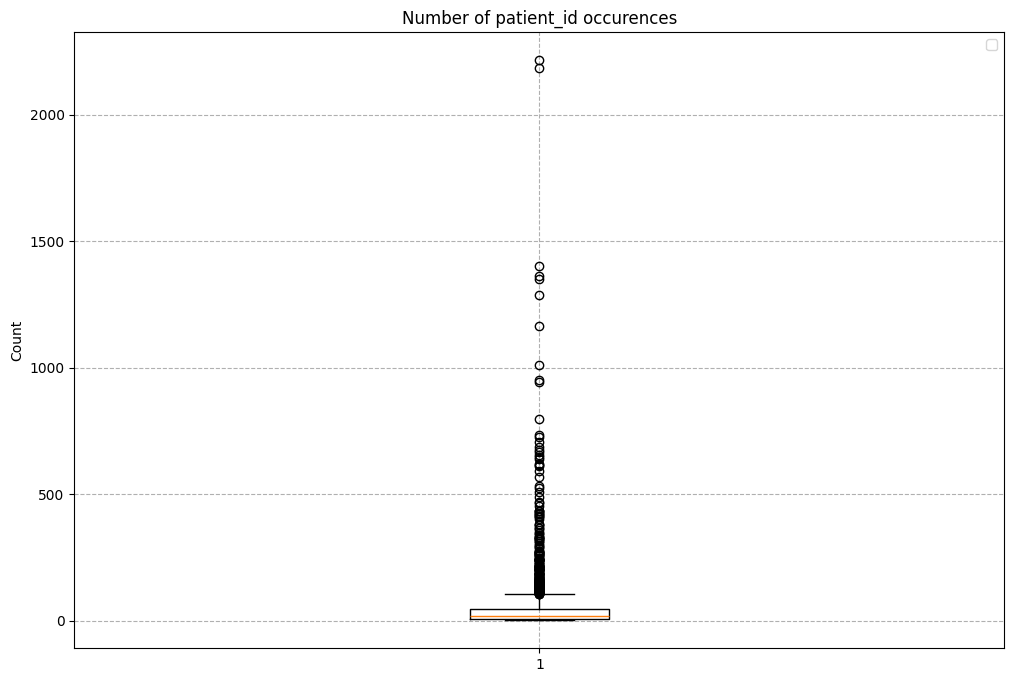

In [156]:
plt.figure(figsize=(12,8))
plt.boxplot(df_count_patient_id['Count'])
plt.ylabel('Count')
plt.title('Number of patient_id occurences')
plt.legend()
plt.grid(ls='--')
plt.show()

In [163]:
# look at a patient with many entries
patient_many_entries = train_df[train_df["patient_id"] == 30631]
patient_many_entries

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
5556,2211351621,0,0.0,96341884,0,0.0,3610302086,30631,Seizure,1,1,0,0,0,1
5557,2211351621,1,6.0,96341884,1,6.0,458558793,30631,Seizure,1,0,0,1,0,1
5558,2211351621,2,10.0,96341884,2,10.0,641984078,30631,Seizure,1,0,0,0,0,0
5559,2211351621,3,34.0,96341884,3,34.0,4266284088,30631,Seizure,1,1,0,0,0,0
5560,2211351621,4,68.0,96341884,4,68.0,4181106031,30631,Seizure,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102517,889003834,1,4.0,2054909634,8,542.0,2491824585,30631,LPD,0,5,0,5,0,1
104151,1681805526,0,0.0,2080096791,0,0.0,519588539,30631,LPD,0,3,0,0,0,0
104152,1681805526,1,4.0,2080096791,1,4.0,2062735829,30631,LPD,0,3,0,0,0,0
104153,1681805526,2,6.0,2080096791,2,6.0,1291157116,30631,LPD,0,3,0,0,0,0


## EEG parquet data

- The EEG data is stored in parquet files, one per EEG ID
- Each file contains a dataframe with 20 channels. 19 are the electrodes of the EEG, the 20th is an EKG channel
- The EEG file is present for each EEG ID in the train.csv. However, there are 211 parquet files that are not referenced in train.csv
- The measurements are between 50 and 3422 seconds (~57 minutes) long
- 6k EEG files are exactly 50 seconds long => these are the ones with exactly one sub window in train.csv
- Many sub windows overlap

### All files

In [135]:
EEG_SAMPLES_PER_SECOND = 200

eegs_file_path = DATA_PATH / "train_eegs"
all_eeg_files = list(eegs_file_path.glob("*.parquet"))
print(f"Total number of EEG files: {len(all_eeg_files)}")

eeg_id_from_files = [np.int64(f.stem) for f in all_eeg_files]
all_eeg_id_in_csv = train_df['eeg_id'].unique()
missing_eeg_files = set(all_eeg_id_in_csv) - set(eeg_id_from_files)
additional_eeg_files = set(eeg_id_from_files) - set(all_eeg_id_in_csv)

print(f"Number of eeg_id in CSV but missing corresponding .parquet file: {len(missing_eeg_files)}")
print(f"Number of additional .parquet files not referenced in CSV: {len(additional_eeg_files)}")

Total number of EEG files: 17300
Number of eeg_id in CSV but missing corresponding .parquet file: 0
Number of additional .parquet files not referenced in CSV: 211


In [136]:
eeg_lengths = []

for eeg_id in tqdm(all_eeg_id_in_csv):
  eeg_file_path = eegs_file_path / f"{eeg_id}.parquet"
  eeg_data = pd.read_parquet(eeg_file_path)
  eeg_lengths.append({"eeg_id": eeg_id, "length": len(eeg_data) / EEG_SAMPLES_PER_SECOND})

eeg_lengths_df = pd.DataFrame(eeg_lengths).sort_values(by='length', ascending=False).reset_index(drop=True)
print(eeg_lengths_df)

100%|██████████| 17089/17089 [02:11<00:00, 129.63it/s]


           eeg_id  length
0      2259539799  3422.0
1      2428433259  3364.0
2       188361788  2600.0
3      1641054670  2492.0
4      2860052642  2384.0
...           ...     ...
17084  3723518273    50.0
17085  3100586988    50.0
17086  2184415503    50.0
17087  1424484930    50.0
17088  3358460067    50.0

[17089 rows x 2 columns]


Max EEG length (seconds) 3422.0
Min EEG length (seconds) 50.0
Mean EEG length (seconds) 80.11048042600503
Median EEG length (seconds) 58.0


/tmp/ipykernel_3140/3981896233.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


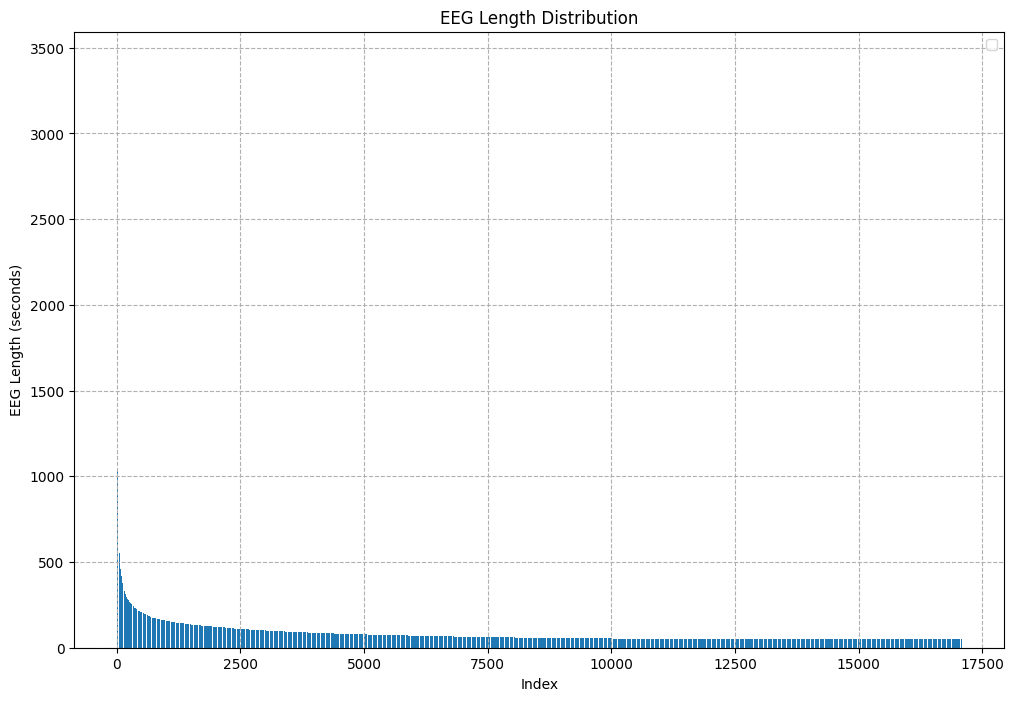

In [137]:
print("Max EEG length (seconds)", eeg_lengths_df['length'].max())
print("Min EEG length (seconds)", eeg_lengths_df['length'].min())
print("Mean EEG length (seconds)", eeg_lengths_df['length'].mean())
print("Median EEG length (seconds)", eeg_lengths_df['length'].median())

plt.figure(figsize=(12,8))
plt.bar(eeg_lengths_df.index, eeg_lengths_df['length'])
plt.xlabel('Index')
plt.ylabel('EEG Length (seconds)')
plt.title('EEG Length Distribution')
plt.legend()
plt.grid(ls='--')
plt.show()

/tmp/ipykernel_3140/2473923172.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


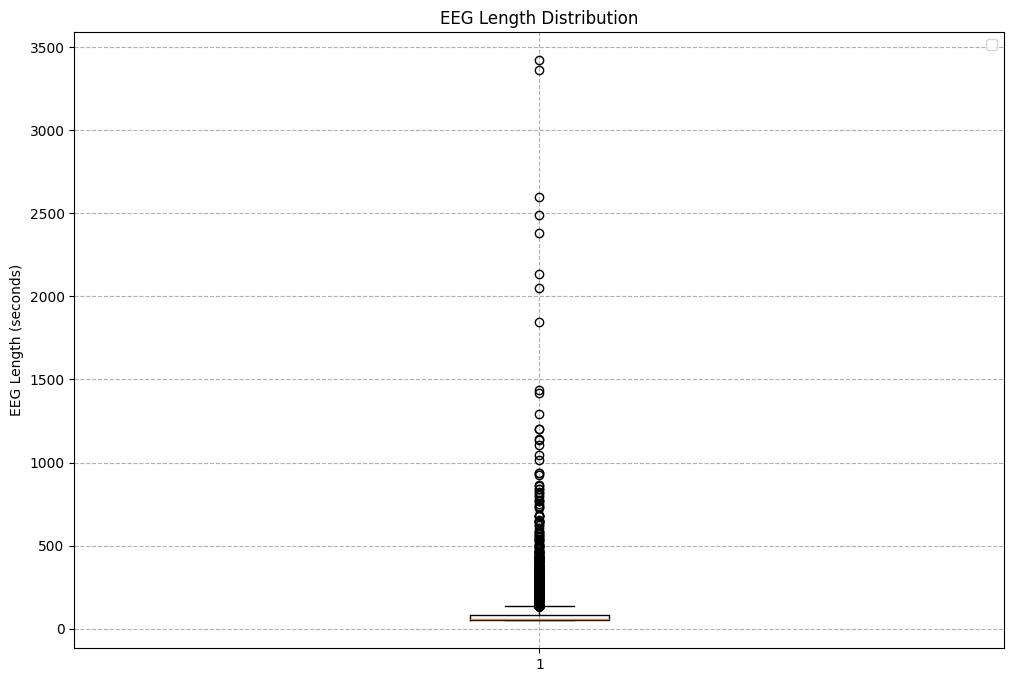

In [155]:
plt.figure(figsize=(12,8))
plt.boxplot(eeg_lengths_df['length'])
plt.ylabel('EEG Length (seconds)')
plt.title('EEG Length Distribution')
plt.legend()
plt.grid(ls='--')
plt.show()

In [138]:
eeg_ids_with_exactly_50_seconds = eeg_lengths_df[eeg_lengths_df['length'] == 50]["eeg_id"]
print(f"Number of eeg_id with exactly 50 seconds length: {len(eeg_ids_with_exactly_50_seconds)}")

# check if all eeg_id with exactly 50 seconds length are exacly once in the train_df
train_df_eeg_id_counts = train_df['eeg_id'].value_counts()
eeg_id_counts_for_50_seconds = train_df_eeg_id_counts[eeg_ids_with_exactly_50_seconds]
print("Any eeg_id with exactly 50 seconds length appearing more than once in train_df?", (eeg_id_counts_for_50_seconds > 1).any())

Number of eeg_id with exactly 50 seconds length: 6324
Any eeg_id with exactly 50 seconds length appearing more than once in train_df? False


### Single file

In [139]:
EEG_ID = 3444840947
EEG_SUBWINDOW_LENGTH_SECONDS = 50

eeg_file_path = eegs_file_path / f"{EEG_ID}.parquet"
eeg_df = pd.read_parquet(eeg_file_path)

print(eeg_df.head())
print("EEG DataFrame shape", eeg_df.shape)
print("Any mising values", eeg_df.isna().any().any())

          Fp1          F3          C3          P3          F7          T3  \
0 -421.350006 -243.509995 -214.529999 -193.000000 -203.630005 -210.009995   
1 -409.660004 -240.320007 -216.130005 -199.910004 -199.380005 -214.270004   
2 -386.000000 -223.039993 -194.589996 -179.179993 -180.240005 -183.960007   
3 -435.440002 -253.880005 -221.440002 -195.919998 -206.289993 -207.350006   
4 -436.510010 -256.529999 -226.759995 -203.100006 -206.289993 -217.720001   

           T5          O1          Fz           Cz          Pz         Fp2  \
0 -374.040009 -172.259995 -325.119995 -1776.599976 -208.679993 -408.329987   
1 -404.339996 -180.500000 -334.690002  -953.299988 -208.949997 -392.640015   
2 -396.899994 -164.020004 -330.440002 -1993.260010 -187.149994 -364.200012   
3 -383.609985 -174.119995 -339.480011 -2182.800049 -207.619995 -419.760010   
4 -389.450012 -175.190002 -341.339996 -1011.520020 -210.009995 -424.279999   

           F4          C4           P4          F8          T4      

In [140]:
eeg_length_seconds = eeg_df.shape[0] / EEG_SAMPLES_PER_SECOND
print("EEG length in seconds", eeg_length_seconds)

eeg_measurements = train_df[train_df['eeg_id'] == EEG_ID].reset_index(drop=True)
print("Amount of sub windows for this EEG in train_df", eeg_measurements.shape[0])

EEG length in seconds 54.0
Amount of sub windows for this EEG in train_df 2


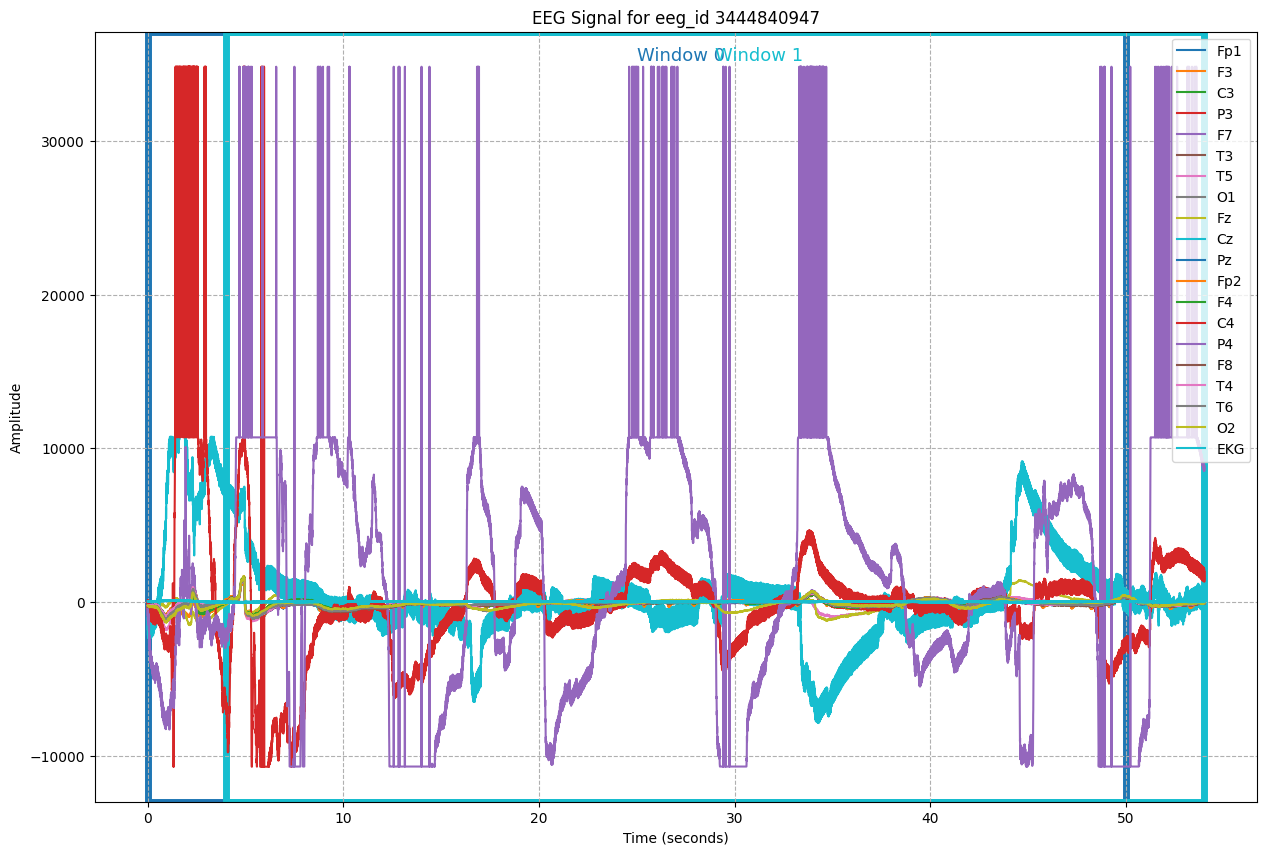

In [141]:
# visualize the eeg by:
# 1) Plotting the length of the eeg using a line plot
# 2) Loop through all 50 seconds measurements and draw a box according to the eeg_label_offset_seconds column

eeg_length_seconds = eeg_df.shape[0] / EEG_SAMPLES_PER_SECOND
time_axis = np.linspace(0, eeg_length_seconds, eeg_df.shape[0])
plt.figure(figsize=(15, 10))
for channel in eeg_df.columns:
    plt.plot(time_axis, eeg_df[channel], label=channel)

subwindow_colors = plt.cm.tab10(np.linspace(0, 1, len(eeg_measurements)))
for i, row in eeg_measurements.iterrows():
    start = row['eeg_label_offset_seconds']
    end = start + EEG_SUBWINDOW_LENGTH_SECONDS 
    plt.axvspan(start, end, fill=False, lw=5, edgecolor=subwindow_colors[i])
    plt.text((start + end) / 2, plt.ylim()[1] * 0.95, f"Window {row['eeg_sub_id']}", color=subwindow_colors[i], fontdict={"fontsize": 13})

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'EEG Signal for eeg_id {EEG_ID}')
plt.legend(loc='upper right')
plt.grid(ls='--')
plt.show()

## Spectrogram parquet data

- The spectrogram data is stored in parquet files, one per spectrogram ID
- Each file contains 401 columns, with one being the `time` in seconds. The other represent the frequencies 0.59-19.92 Hz for 4 regions: LL (left lateral), LP (left parasagittal), RP (right parasagittal), RL (right lateral). This equals 400 / 4 = 100 frequencies per region, so the frequency resolution is 0.2 Hz
- The spectrogram IDs match exactly those in train.csv
- The measurements are between 600 and 18232 seconds (10 - ~303 minutes) long
- 2430 spectrogram files are exactly 600 seconds long => these are the ones with exactly one sub window in train.csv

### All files

In [4]:
SPECTROGRAM_SAMPLES_PER_SECOND = 0.5 # 1 sample every 2 seconds

spectrograms_file_path = DATA_PATH / "train_spectrograms"
all_spectrogram_files = list(spectrograms_file_path.glob("*.parquet"))
print(f"Total number of spectrogram files: {len(all_spectrogram_files)}")

spectrogram_id_from_files = [np.int64(f.stem) for f in all_spectrogram_files]
all_spectrogram_id_in_csv = train_df['spectrogram_id'].unique()
missing_spectrogram_files = set(all_spectrogram_id_in_csv) - set(spectrogram_id_from_files)
additional_spectrogram_files = set(spectrogram_id_from_files) - set(all_spectrogram_id_in_csv)

print(f"Number of spectrogram_id in CSV but missing corresponding .parquet file: {len(missing_spectrogram_files)}")
print(f"Number of additional .parquet files not referenced in CSV: {len(additional_spectrogram_files)}")

Total number of spectrogram files: 11138
Number of spectrogram_id in CSV but missing corresponding .parquet file: 0
Number of additional .parquet files not referenced in CSV: 0


In [143]:
spectrogram_lengths = []

for spectrogram_id in tqdm(all_spectrogram_id_in_csv):
  spectrogram_file_path = spectrograms_file_path / f"{spectrogram_id}.parquet"
  spectrogram_data = pd.read_parquet(spectrogram_file_path)
  spectrogram_lengths.append({"spectrogram_id": spectrogram_id, "length": len(spectrogram_data) / SPECTROGRAM_SAMPLES_PER_SECOND})

spectrogram_lengths_df = pd.DataFrame(spectrogram_lengths).sort_values(by='length', ascending=False).reset_index(drop=True)
print(spectrogram_lengths_df)

100%|██████████| 11138/11138 [07:06<00:00, 26.12it/s]

       spectrogram_id   length
0           764146759  18232.0
1          1863712617  13500.0
2          2060670605  11484.0
3          1908433744  10562.0
4          1343094925   9788.0
...               ...      ...
11133      1662756242    600.0
11134      1662066256    600.0
11135      1661391047    600.0
11136      1661353529    600.0
11137      1665490767    600.0

[11138 rows x 2 columns]


Max spectrogram length (seconds) 18232.0
Min spectrogram length (seconds) 600.0
Mean spectrogram length (seconds) 768.4514275453403
Median spectrogram length (seconds) 622.0


/tmp/ipykernel_3140/2767330057.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


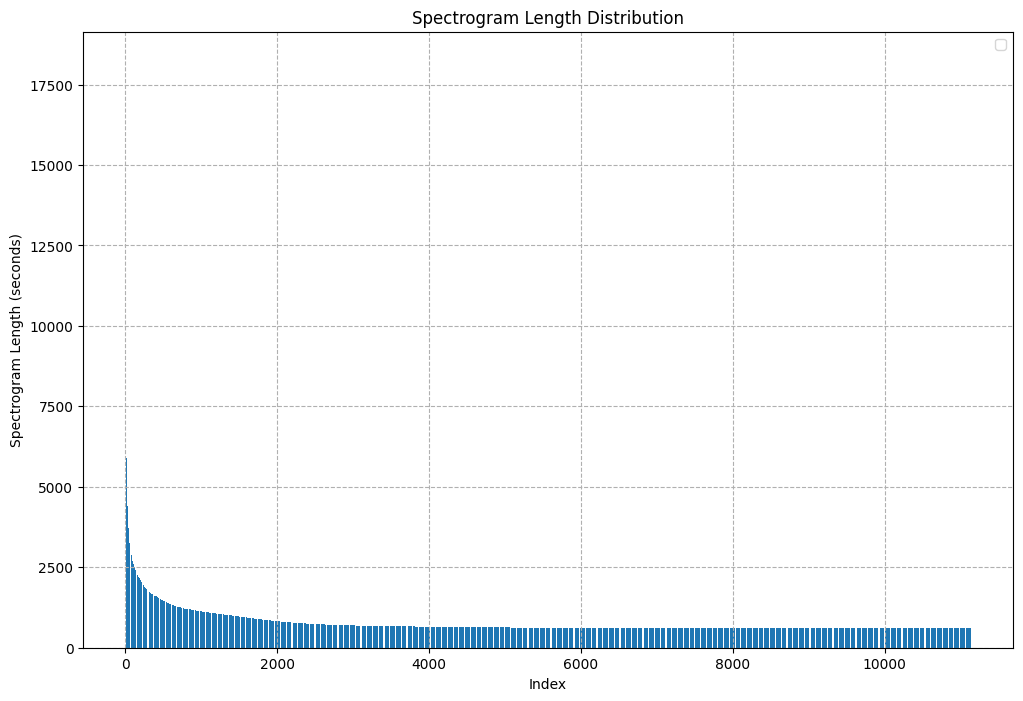

In [144]:
print("Max spectrogram length (seconds)", spectrogram_lengths_df['length'].max())
print("Min spectrogram length (seconds)", spectrogram_lengths_df['length'].min())
print("Mean spectrogram length (seconds)", spectrogram_lengths_df['length'].mean())
print("Median spectrogram length (seconds)", spectrogram_lengths_df['length'].median())

plt.figure(figsize=(12,8))
plt.bar(spectrogram_lengths_df.index, spectrogram_lengths_df['length'])
plt.xlabel('Index')
plt.ylabel('Spectrogram Length (seconds)')
plt.title('Spectrogram Length Distribution')
plt.legend()
plt.grid(ls='--')
plt.show()

In [145]:
spectrogram_ids_with_exactly_600_seconds = spectrogram_lengths_df[spectrogram_lengths_df['length'] == 600]["spectrogram_id"]
print(f"Number of spectrogram_id with exactly 600 seconds length: {len(spectrogram_ids_with_exactly_600_seconds)}")

# check if all spectrogram_id with exactly 600 seconds length are exacly once in the train_df
train_df_spectrogram_id_counts = train_df['spectrogram_id'].value_counts()
spectrogram_id_counts_for_600_seconds = train_df_spectrogram_id_counts[spectrogram_ids_with_exactly_600_seconds]
print("Any spectrogram_id with exactly 600 seconds length appearing more than once in train_df?", (spectrogram_id_counts_for_600_seconds > 1).any())

Number of spectrogram_id with exactly 600 seconds length: 2430
Any spectrogram_id with exactly 600 seconds length appearing more than once in train_df? False


### Single file

In [5]:
SPECTROGRAM_ID = 566981767
SPECTROGRAM_SUBWINDOW_LENGTH_SECONDS = 600 # 10 minutes

spectrogram_file_path = spectrograms_file_path / f"{SPECTROGRAM_ID}.parquet"
spectrogram_df = pd.read_parquet(spectrogram_file_path)

print(spectrogram_df.head())
print("Spectrogram DataFrame shape", spectrogram_df.shape)
print("Any mising values", spectrogram_df.isna().any().any())

   time    LL_0.59    LL_0.78    LL_0.98    LL_1.17    LL_1.37    LL_1.56  \
0     1  17.910000  20.940001  26.590000  18.110001  20.150000  13.220000   
1     3  19.610001  19.740000  25.340000  25.580000  31.969999  36.740002   
2     5  24.059999  29.620001  31.010000  38.470001  23.549999  28.340000   
3     7  15.070000  23.590000  25.629999  25.010000  22.549999  23.379999   
4     9   6.490000  10.060000  13.790000  16.350000  19.389999  20.879999   

     LL_1.76    LL_1.95    LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  \
0   8.540000   6.590000   4.330000  ...      0.20      0.15      0.11   
1  29.150000  27.209999  17.620001  ...      0.16      0.15      0.16   
2  21.270000  15.530000  14.220000  ...      0.06      0.07      0.06   
3  25.360001  20.320000  17.530001  ...      0.05      0.05      0.06   
4  17.160000  14.880000  15.920000  ...      0.04      0.05      0.04   

   RP_18.75  RP_18.95  RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0      0.09      0.10   

In [6]:
# print the spectrogram's columns
print(spectrogram_df.columns.tolist())

['time', 'LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37', 'LL_1.56', 'LL_1.76', 'LL_1.95', 'LL_2.15', 'LL_2.34', 'LL_2.54', 'LL_2.73', 'LL_2.93', 'LL_3.13', 'LL_3.32', 'LL_3.52', 'LL_3.71', 'LL_3.91', 'LL_4.1', 'LL_4.3', 'LL_4.49', 'LL_4.69', 'LL_4.88', 'LL_5.08', 'LL_5.27', 'LL_5.47', 'LL_5.66', 'LL_5.86', 'LL_6.05', 'LL_6.25', 'LL_6.45', 'LL_6.64', 'LL_6.84', 'LL_7.03', 'LL_7.23', 'LL_7.42', 'LL_7.62', 'LL_7.81', 'LL_8.01', 'LL_8.2', 'LL_8.4', 'LL_8.59', 'LL_8.79', 'LL_8.98', 'LL_9.18', 'LL_9.38', 'LL_9.57', 'LL_9.77', 'LL_9.96', 'LL_10.16', 'LL_10.35', 'LL_10.55', 'LL_10.74', 'LL_10.94', 'LL_11.13', 'LL_11.33', 'LL_11.52', 'LL_11.72', 'LL_11.91', 'LL_12.11', 'LL_12.3', 'LL_12.5', 'LL_12.7', 'LL_12.89', 'LL_13.09', 'LL_13.28', 'LL_13.48', 'LL_13.67', 'LL_13.87', 'LL_14.06', 'LL_14.26', 'LL_14.45', 'LL_14.65', 'LL_14.84', 'LL_15.04', 'LL_15.23', 'LL_15.43', 'LL_15.63', 'LL_15.82', 'LL_16.02', 'LL_16.21', 'LL_16.41', 'LL_16.6', 'LL_16.8', 'LL_16.99', 'LL_17.19', 'LL_17.38', 'LL_1

In [13]:
flattened_values = spectrogram_df.values.flatten()
print("Spectrogram values shape", flattened_values.shape)
print(f"Min value: {flattened_values.min()}, Max value: {flattened_values.max()}, Mean value: {flattened_values.mean()}, Median value: {np.median(flattened_values)}")
print(f"Values over 99th percentile: {np.sum(flattened_values > np.percentile(flattened_values, 99))}")

Spectrogram values shape (224560,)
Min value: 0.009999999776482582, Max value: 60143.76171875, Mean value: 10.196412983804422, Median value: 0.36000001430511475
Values over 99th percentile: 2246


/tmp/ipykernel_7126/1512969162.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


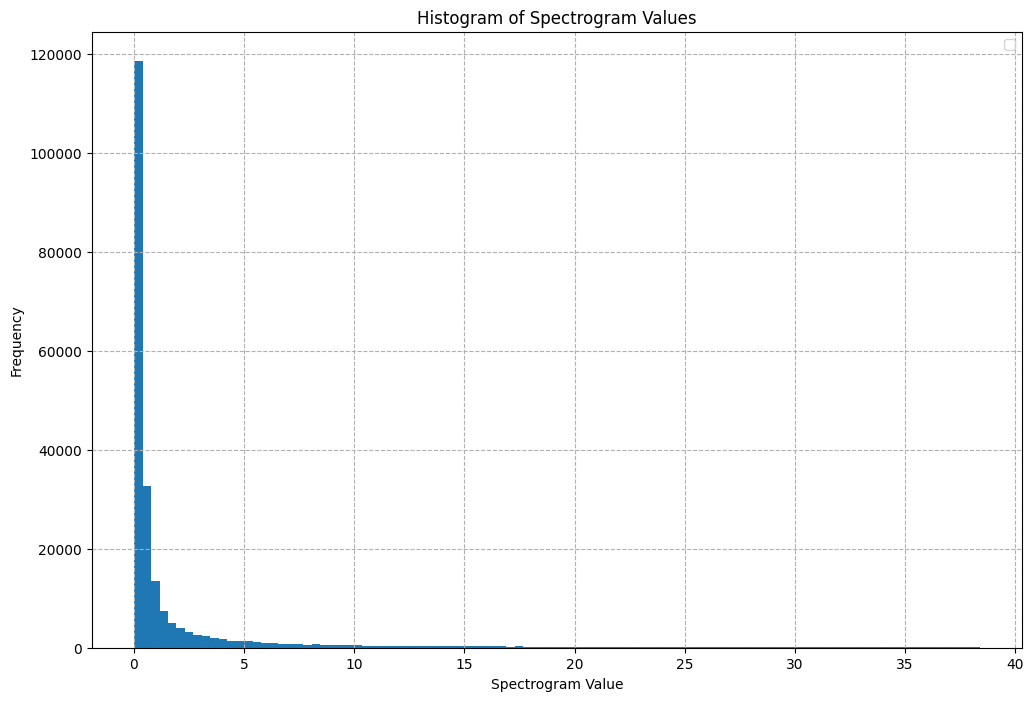

In [15]:
flattened_values = flattened_values[flattened_values <= np.percentile(flattened_values, 99)]

# create histogram of all values
plt.figure(figsize=(12,8))
plt.hist(flattened_values, bins=100)
plt.xlabel('Spectrogram Value')
plt.ylabel('Frequency')
plt.title('Histogram of Spectrogram Values')
plt.legend()
plt.grid(ls='--')